# Catalogue Query Tools

This notebook provides examples on how to use the Catalogue Toolkit to build and explore a catalogue database:

In [1]:
%matplotlib inline
import os, sys
sys.path.append('/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages')
import numpy as np
import matplotlib.pyplot as plt
from eqcat.parsers.isf_catalogue_reader import ISFReader
import eqcat.catalogue_query_tools as cqt

## Constructing the Database

In [2]:
# Read in the catalogue
parser = ISFReader("inputs/isc_test_catalogue_isf.txt")
catalogue1 = parser.read_file("ISC_DB1", "ISC Global M >= 5")
print "Catalogue contains: %d events" % catalogue1.get_number_events()

Catalogue contains: 9685 events


In [3]:
# Build the HDF5 Database
database_file = "outputs/catalogue_db1.hdf5"
if os.path.exists(database_file):
    os.remove(database_file)
_ = catalogue1.build_dataframe(hdf5_file=database_file)

## Using the Database

In [4]:
db1 = cqt.CatalogueDB(database_file)

### Apply Limiting Selections

#### By Bounding Box

In [5]:
lower_lon = 15.
upper_lon = 30.
lower_lat = 30.
upper_lat = 45.
bbox = [lower_lon, upper_lon, lower_lat, upper_lat]
selector = cqt.CatalogueSelector(db1)
aegean_cat = selector.select_within_bounding_box(bbox)

In [6]:
number_origins, number_magnitudes = aegean_cat._get_number_origins_magnitudes()
print "Number of Origins = %d, Number of Magnitudes = %d" % (number_origins,
                                                             number_magnitudes)

Number of Origins = 2267, Number of Magnitudes = 4116


#### By Polygon

In [7]:
polygon = np.array([[15.0, 45.0],
                    [30.0, 45.0],
                    [30.0, 30.0],
                    [15.0, 30.0],
                    [15.0, 45.0]])
selector2 = cqt.CatalogueSelector(db1)
aegean_cat_alt = selector2.select_within_polygon(polygon[:, 0], polygon[:, 1])
number_origins, number_magnitudes = aegean_cat_alt._get_number_origins_magnitudes()
print "Number of Origins = %d, Number of Magnitudes = %d" % (number_origins,
                                                             number_magnitudes)

Number of Origins = 2267, Number of Magnitudes = 4116


#### By Magnitude

In [8]:
# Above magnitude 6.0
selector3 = cqt.CatalogueSelector(aegean_cat)
aegean_cat_m6 = selector3.select_within_magnitude_range(lower_mag=6.0, upper_mag=9.0)
number_origins, number_magnitudes = aegean_cat_m6._get_number_origins_magnitudes()
print "Number of Origins = %d, Number of Magnitudes = %d" % (number_origins,
                                                             number_magnitudes)

Number of Origins = 176, Number of Magnitudes = 287


#### By Depth

In [9]:
selector4 = cqt.CatalogueSelector(aegean_cat_alt)
aegean_cat_deep = selector4.select_within_depth_range(upper_depth=50.0, lower_depth=200.0)
number_origins, number_magnitudes = aegean_cat_deep._get_number_origins_magnitudes()
print "Number of Origins = %d, Number of Magnitudes = %d" % (number_origins,
                                                             number_magnitudes)

Number of Origins = 1021, Number of Magnitudes = 1845


## Exploring the Catalogue Database

### See Summary of Agencies and Magnitudes in the Catalogue

In [10]:
agency_count = cqt.get_agency_magtype_statistics(db1)

Agency: NEIC - 9443 Origins
mb (9716) | MS (1930) | MW (819) | ME (327) | ML (2) | MD (1) | Mw (1)
Agency: ISC - 9423 Origins
mb (9399) | MS (6798)
Agency: IDC - 9124 Origins
mbtmp (9121) | mb1mx (9121) | mb1 (9121) | mb (9121) | Ms1 (7364) | MS (7364) | ms1mx (7364) | ML (5440)
Agency: BJI - 8549 Origins
mB (8341) | mb (7500) | Ms (6790) | Msz (6764) | ML (459)
Agency: EHB - 8018 Origins
No magnitudes corresponding to this agency
Agency: MOS - 6963 Origins
mb (6958) | MS (2246) | MW (28)
Agency: ISCJB - 4549 Origins
mb (4541) | MS (3173)
Agency: HRVD - 3197 Origins
MW (3204)
Agency: SZGRF - 1476 Origins
mb (1281) | MS (338) | ML (3)
Agency: CSEM - 999 Origins
mb (907) | Ms (227) | ML (136) | Mw (92) | MS (2) | MW (2) | MD (1)
Agency: JMA - 742 Origins
UK (739) | MG (2)
Agency: NIED - 717 Origins
Mw (717) | MW (341)
Agency: MAN - 568 Origins
ML (535) | mb (534) | MS (446)
Agency: GCMT - 540 Origins
MW (540)
Agency: LDG - 487 Origins
Mb (400) | Ms (292) | Ml (53) | ms (20) | Md (15) | M

### Search for a Specific Agency-Magnitude Combination

Search for body-wave magnitude common to 'BJI' and 'ISC'

In [11]:
query_bji_isc_mb, bji_isc_mb_cat = cqt.get_agency_magnitude_pairs(db1, ("BJI", "mb"), ("ISC", "mb"), no_case=True)

Agency-Pairs: (BJI, mb) & (ISC, mb) returned 8482 events


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


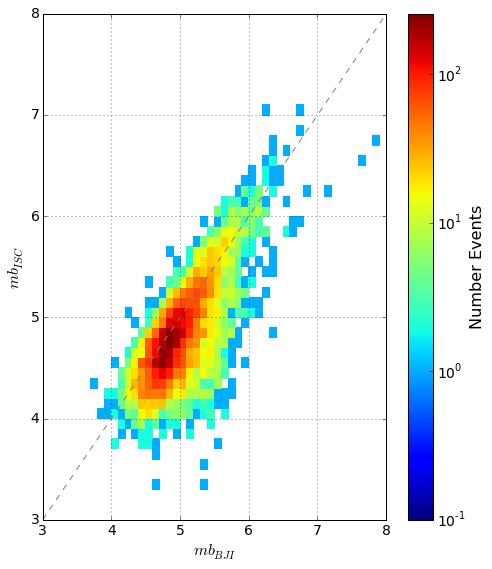

In [12]:
_ = cqt.plot_agency_magnitude_density(query_bji_isc_mb)

### Join Query Results

Join together the results of two queries. For example the Global CMT magnitudes are reported under either
'GCMT' or 'HRVD'. So search for both terms

In [13]:
query1, cat1 = cqt.get_agency_magnitude_pairs(db1, ("BJI", "Ms"), ("GCMT", "Mw"), no_case=True)
query2, cat2 = cqt.get_agency_magnitude_pairs(db1, ("BJI", "Ms"), ("HRVD", "Mw"), no_case=True)
query_bji_gcmt_ms = cqt.join_query_results(query1, query2)

Agency-Pairs: (BJI, Ms) & (GCMT, Mw) returned 440 events
Agency-Pairs: (BJI, Ms) & (HRVD, Mw) returned 2690 events


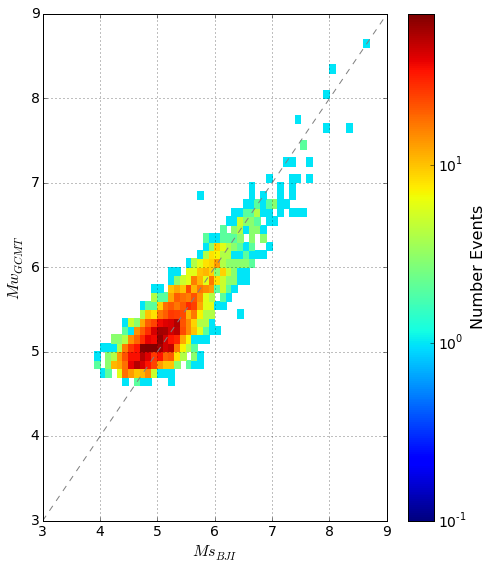

In [14]:
_ = cqt.plot_agency_magnitude_density(query_bji_gcmt_ms)

## Regression Tools

In this example we compare the $M_S$ scale as recorded by the BJI network with the $M_W$ scale reported by
HRVD/GCMT (from the previous query)

#### Set up the regression

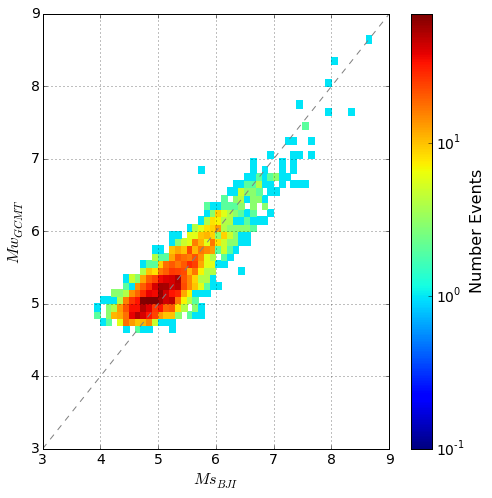

In [15]:
regressor = cqt.CatalogueRegressor(query_bji_gcmt_ms)
regressor.plot_density(overlay=False)

#### Apply a Linear Model 

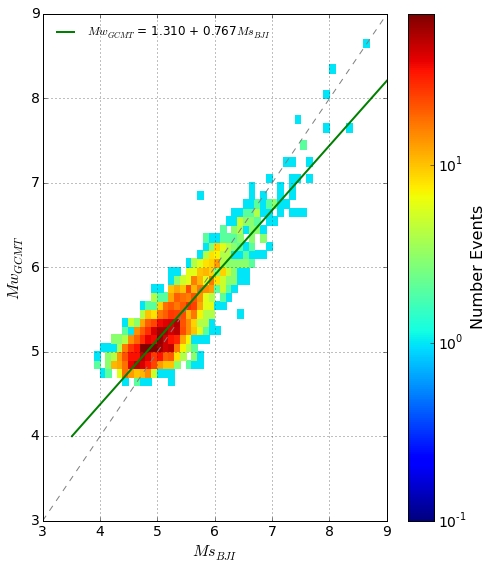

Mw = 1.310 + 0.767 MS +/- 0.221


In [16]:
linear_model = regressor.run_regression("polynomial", # Model Type
                                        [0., 1.]) # Initial guess of parameters
regressor.plot_model_density(False, 0)
# View Results
print "Mw = %.3f + %.3f MS +/- %.3f" % (regressor.results.beta[0],
                                        regressor.results.beta[1],
                                        regressor.standard_deviation)

### Apply a Piecewise Linear Model

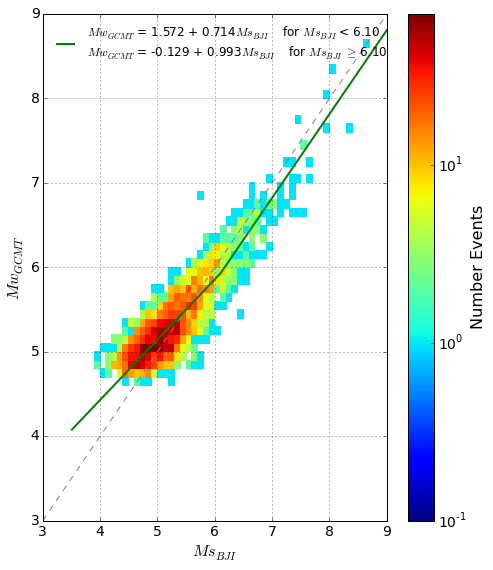

Standard Deviation - Segment 1: 0.212, Segment 2: 0.256


In [17]:
initial_guess = [1.0, 1.0, 0.0]  # [slope 1, slope 2, intercept]

linear_model = regressor.run_regression("2segmentM6.1", # Model Type
                                        initial_guess) # Initial guess of parameters
regressor.plot_model_density(False, 0)
print "Standard Deviation - Segment 1: %.3f, Segment 2: %.3f" % (regressor.standard_deviation[0],
                                                                 regressor.standard_deviation[1])